In [4]:
import os

import pandas as pd
import tiktoken
from utils import completion,df_to_html

from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)
from graphrag.query.input.loaders.dfs import (
    store_entity_semantic_embeddings,
)
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.embedding import OpenAIEmbedding
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.question_gen.local_gen import LocalQuestionGen
from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,build_text_unit_context,LocalContextBuilder
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores.lancedb import LanceDBVectorStore



import os

import pandas as pd
import tiktoken

from graphrag.query.indexer_adapters import read_indexer_entities, read_indexer_reports
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.structured_search.global_search.community_context import (
    GlobalCommunityContext,
)
from graphrag.query.structured_search.global_search.search import GlobalSearch



In [5]:
#INPUT_DIR = "./inputs/operation dulce"
INPUT_DIR = "/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/elec_graph/output"
LANCEDB_URI = f"{INPUT_DIR}/lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 2

In [6]:
# read nodes table to get community and degree data
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
# to connect to a remote db, specify url and port values.

description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)

print(f"Entity count: {len(entity_df)}")

entity_df.head()

Entity count: 2229


,level,title,type,description,source_id,degree,human_readable_id,id,graph_embedding,community,size,entity_type,top_level_node_id,x,y
0,0,MIKE JUDD,PERSON,"Mike Judd is an author of the book ""Soldering ...",e82f9f1a4a5f409251687ca54991574a,2,0,fb1ad80c6e4842c2ac554e156ce593f5,None,None,NaN,None,fb1ad80c6e4842c2ac554e156ce593f5,NaN,NaN
1,0,KEITH BRINDLEY,PERSON,"Keith Brindley is an author of the book ""Solde...",e82f9f1a4a5f409251687ca54991574a,2,1,fbb428960ebc4729b5e2e1c4d0eaabfe,None,None,NaN,None,fbb428960ebc4729b5e2e1c4d0eaabfe,NaN,NaN
2,0,NEWNES,ORGANIZATION,"Newnes is the publisher of the book ""Soldering...",e82f9f1a4a5f409251687ca54991574a,9,2,7c9524a8d3a545768248a79e49a4d846,None,None,NaN,None,7c9524a8d3a545768248a79e49a4d846,NaN,NaN
3,0,BUTTERWORTH-HEINEMANN,ORGANIZATION,Butterworth-Heinemann is the parent company of...,e82f9f1a4a5f409251687ca54991574a,2,3,24c36d4df1d645dab616505a361365fd,None,None,NaN,None,24c36d4df1d645dab616505a361365fd,NaN,NaN
4,0,REED EDUCATIONAL AND PROFESSIONAL PUBLISHING LTD,ORGANIZATION,Reed Educational and Professional Publishing L...,e82f9f1a4a5f409251687ca54991574a,2,4,38041978d9114fc9842436b762783fae,None,None,NaN,None,38041978d9114fc9842436b762783fae,NaN,NaN


In [7]:
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

print(f"Relationship count: {len(relationship_df)}")
relationship_df.head()

Relationship count: 3179


,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
0,MIKE JUDD,NEWNES,5.0,Mike Judd is an author of a book published by ...,[e82f9f1a4a5f409251687ca54991574a],2253aca4b1544f899ab80a6bcac6a6c4,0,2,9,11
1,MIKE JUDD,SOLDERING IN ELECTRONICS ASSEMBLY,5.0,"Mike Judd is an author of the book ""Soldering ...",[e82f9f1a4a5f409251687ca54991574a],dd2c46e8c5aa42888c4011c9490cc0ab,1,2,4,6
2,KEITH BRINDLEY,NEWNES,5.0,Keith Brindley is an author of a book publishe...,[e82f9f1a4a5f409251687ca54991574a],d9b99f755a494293ac9627a0a01b0b52,2,2,9,11
3,KEITH BRINDLEY,SOLDERING IN ELECTRONICS ASSEMBLY,5.0,"Keith Brindley is an author of the book ""Solde...",[e82f9f1a4a5f409251687ca54991574a],7ecd045f2385449fba6f653a0c0920a3,3,2,4,6
4,NEWNES,BUTTERWORTH-HEINEMANN,8.0,Newnes is an imprint of Butterworth-Heinemann,[e82f9f1a4a5f409251687ca54991574a],983ea8ae7ad643f98eea079002fadcf2,4,9,2,11


In [8]:
# NOTE: covariates are turned off by default, because they generally need prompt tuning to be valuable
# Please see the GRAPHRAG_CLAIM_* settings
"""covariate_df = pd.read_parquet(f"{INPUT_DIR}/{COVARIATE_TABLE}.parquet")

claims = read_indexer_covariates(covariate_df)

print(f"Claim records: {len(claims)}")
covariates = {"claims": claims}"""

'covariate_df = pd.read_parquet(f"{INPUT_DIR}/{COVARIATE_TABLE}.parquet")\n\nclaims = read_indexer_covariates(covariate_df)\n\nprint(f"Claim records: {len(claims)}")\ncovariates = {"claims": claims}'

In [9]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)

print(f"Report records: {len(report_df)}")
report_df.head()

Report records: 73


,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,58,# Soldering and Electronics Assembly\n\nThis c...,2,7.0,Soldering and Electronics Assembly,The impact severity rating is high due to the ...,This community revolves around the process of ...,[{'explanation': 'Soldering is the central ent...,"{\n ""title"": ""Soldering and Electronics Ass...",b35de978-ca01-44d7-a012-7b6526ae3412
1,59,# Flux and Solderability\n\nThis community rev...,2,3.0,Flux and Solderability,The impact severity rating is low due to the l...,This community revolves around the concept of ...,[{'explanation': 'Flux is a key entity in this...,"{\n ""title"": ""Flux and Solderability"",\n ...",287df284-3c47-4e78-8024-7bfed14af4ee
2,60,# Assembly and its Associated Faults\n\nThis c...,2,7.0,Assembly and its Associated Faults,The impact severity rating is high due to the ...,This community revolves around the concept of ...,[{'explanation': 'Assembly is a fundamental pr...,"{\n ""title"": ""Assembly and its Associated F...",797c3220-46e5-4c6f-9a3a-83da48391eb3
3,61,# Component Assembly and Manufacturing\n\nThis...,2,7.0,Component Assembly and Manufacturing,The impact severity rating is high due to the ...,This community focuses on the assembly and man...,[{'explanation': 'Components are the fundament...,"{\n ""title"": ""Component Assembly and Manufa...",65dff29b-096d-4a55-aaef-66de20e2de64
4,62,# Electrical Connections and Circuits\n\nThis ...,2,3.0,Electrical Connections and Circuits,The impact severity rating is low due to the t...,This community revolves around the concept of ...,[{'explanation': 'Soldering is a crucial techn...,"{\n ""title"": ""Electrical Connections and Ci...",d294c6d5-ba91-42de-a01e-1aa6c4b21978


In [10]:
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

print(f"Text unit records: {len(text_unit_df)}")
text_unit_df.head()


Text unit records: 28


,id,text,n_tokens,document_ids,entity_ids,relationship_ids
0,e82f9f1a4a5f409251687ca54991574a,"6G a®*: s +. i 2 a <, s e Ged SECOND EDITION\n...",791,[soldering.pdf_0],"[fb1ad80c6e4842c2ac554e156ce593f5, fbb428960eb...","[2253aca4b1544f899ab80a6bcac6a6c4, dd2c46e8c5a..."
1,e79b884d7685eec5915f598876065fa0,Foreword\n\nPreface\n\nAcknowledgements\n\n1 S...,830,[soldering.pdf_1],"[3bfa928fa72346a9bd36df9d18e29d46, e40202c25c8...","[18a22fbd59984239829041aaa1f09ce5, 79bcefb0932..."
2,8283f5a9bf11a066788202bdc6651675,TIME ON ITS SIDE 3\n\nmake up the circuit of a...,796,[soldering.pdf_10],"[3bfa928fa72346a9bd36df9d18e29d46, e40202c25c8...","[99835832c2f3439880b49c6c38bf68d3, 0ee567e423b..."
3,6927c3447dc3d9eeaa6e89e04ae5a84b,PRINTED CIRCUIT BOARD 5 Printed circuit board ...,773,[soldering.pdf_11],"[3bfa928fa72346a9bd36df9d18e29d46, e40202c25c8...","[18a22fbd59984239829041aaa1f09ce5, c17ec52ee3b..."
4,a666a3f859c5aa120085c1c8e136a832,6 SOLDERING PROCESS\n\nHole through board Comp...,634,[soldering.pdf_12],"[3bfa928fa72346a9bd36df9d18e29d46, 3b642c945e2...","[05f6641eec57433c913257e8a092a183, 70aa84654a9..."


In [11]:

import litellm
#api_key = os.environ["GRAPHRAG_API_KEY"]
#llm_model = os.environ["GRAPHRAG_LLM_MODEL"]
#embedding_model = os.environ["GRAPHRAG_EMBEDDING_MODEL"]

BASE_URL = "http://localhost:8080/"
MODEL_NAME = "gpt-4o"
litellm.set_verbose = False
temperature = 0.7

llm = ChatOpenAI(
    api_key="api_key",
    model=MODEL_NAME,
    api_type=OpenaiApiType.OpenAI,  # OpenaiApiType.OpenAI or OpenaiApiType.AzureOpenAI
    max_retries=20,
    api_base=BASE_URL,
    
)
token_encoder = tiktoken.get_encoding("cl100k_base")

text_embedder = OpenAIEmbedding(
    api_key="api_key",
    api_base=BASE_URL,
    api_type=OpenaiApiType.OpenAI,
    model='text',
    deployment_name='text',
    max_retries=20,
)


In [12]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    # if you did not run covariates during indexing, set this to None
    #covariates=covariates,
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  # if the vectorstore uses entity title as ids, set this to EntityVectorStoreKey.TITLE
    text_embedder=text_embedder,
    token_encoder=token_encoder,

)

In [13]:
print(context_builder.build_context("flux")[0])

-----Reports-----
id|title|content
58|Soldering and Electronics Assembly|"# Soldering and Electronics Assembly

This community revolves around the process of soldering, which is used to join metal parts together, particularly in the context of electronics assembly. The community includes various entities related to soldering, such as solder, flux, solder pots and pumps, and solder pot heaters. It also encompasses broader concepts like safety, cleanliness, and assembly variations. The community's focus on electronics assembly highlights its importance in the manufacturing of electronic devices.

## Soldering as a core process

Soldering is the central entity in this community, serving as the primary process for joining metal parts together, particularly in electronics assembly. This process involves melting and flowing solder into the joint between two metal parts, creating a strong and reliable bond. [Data: Entities (13); Relationships (58, 71, 175, 74, 86, +more)]

## Importance of so

In [14]:
# text_unit_prop: proportion of context window dedicated to related text units
# community_prop: proportion of context window dedicated to community reports.
# The remaining proportion is dedicated to entities and relationships. Sum of text_unit_prop and community_prop should be <= 1
# conversation_history_max_turns: maximum number of turns to include in the conversation history.
# conversation_history_user_turns_only: if True, only include user queries in the conversation history.
# top_k_mapped_entities: number of related entities to retrieve from the entity description embedding store.
# top_k_relationships: control the number of out-of-network relationships to pull into the context window.
# include_entity_rank: if True, include the entity rank in the entity table in the context window. Default entity rank = node degree.
# include_relationship_weight: if True, include the relationship weight in the context window.
# include_community_rank: if True, include the community rank in the context window.
# return_candidate_context: if True, return a set of dataframes containing all candidate entity/relationship/covariate records that
# could be relevant. Note that not all of these records will be included in the context window. The "in_context" column in these
# dataframes indicates whether the record is included in the context window.
# max_tokens: maximum number of tokens to use for the context window.


local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  # set this to EntityVectorStoreKey.TITLE if the vectorstore uses entity title as ids
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
}

llm_params = {
    "max_tokens": 2_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000=1500)
    "temperature": temperature,
}

In [15]:
from graphrag.query.structured_search.local_search.system_prompt import (
    LOCAL_SEARCH_SYSTEM_PROMPT
)
print(LOCAL_SEARCH_SYSTEM_PROMPT)


---Role---

You are a helpful assistant responding to questions about data in the tables provided.


---Goal---

Generate a response of the target length and format that responds to the user's question, summarizing all information in the input data tables appropriate for the response length and format, and incorporating any relevant general knowledge.

If you don't know the answer, just say so. Do not make anything up.

Points supported by data should list their data references as follows:

"This is an example sentence supported by multiple data references [Data: <dataset name> (record ids); <dataset name> (record ids)]."

Do not list more than 5 record ids in a single reference. Instead, list the top 5 most relevant record ids and add "+more" to indicate that there are more.

For example:

"Person X is the owner of Company Y and subject to many allegations of wrongdoing [Data: Sources (15, 16), Reports (1), Entities (5, 7); Relationships (23); Claims (2, 7, 34, 46, 64, +more)]."

whe

In [16]:
localsearch = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

In [17]:
context_builder = GlobalCommunityContext(
    community_reports=reports,
    entities=entities,  # default to None if you don't want to use community weights for ranking
    token_encoder=token_encoder,
)
context_builder_params = {
    "use_community_summary": False,  # False means using full community reports. True means using community short summaries.
    "shuffle_data": True,
    "include_community_rank": True,
    "min_community_rank": 0,
    "community_rank_name": "rank",
    "include_community_weight": True,
    "community_weight_name": "occurrence weight",
    "normalize_community_weight": True,
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    "context_name": "Reports",
}

map_llm_params = {
    "max_tokens": 1000,
    "temperature": temperature,
    "response_format": {"type": "json_object"},
}

reduce_llm_params = {
    "max_tokens": 2000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000-1500)
    "temperature": temperature,
}
globalsearch = GlobalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    max_data_tokens=12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    map_llm_params=map_llm_params,
    reduce_llm_params=reduce_llm_params,
    allow_general_knowledge=False,  # set this to True will add instruction to encourage the LLM to incorporate general knowledge in the response, which may increase hallucinations, but could be useful in some use cases.
    json_mode=True,  # set this to False if your LLM model does not support JSON mode.
    context_builder_params=context_builder_params,
    concurrent_coroutines=32,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

In [18]:
"""import chromadb
client = chromadb.PersistentClient('chroma_docs')
col_questions = client.get_or_create_collection('questions')
all_json = col_questions.get()['documents']
import json_repair

all_questions =[]
for j in all_json:
    all_questions.extend( json_repair.loads(j) )

all_questions"""

"import chromadb\nclient = chromadb.PersistentClient('chroma_docs')\ncol_questions = client.get_or_create_collection('questions')\nall_json = col_questions.get()['documents']\nimport json_repair\n\nall_questions =[]\nfor j in all_json:\n    all_questions.extend( json_repair.loads(j) )\n\nall_questions"

In [19]:
from utils import answer_to_quesion,electronic_collection
import time


#question = all_questions[-1]['Question']
#question = "9 What are some of the potential consequences of using laminates that do not meet the standards set by BS 4584?" #RAG
questions=[
 "What are letter codes in the context of BS 4584?" ,#GR
 "How does soldering potentially contribute to peaceful pursuits?",#None
 "How does soldering contribute to the development of intelligent machines?",#GR
 "How does LEAD contribute to the depletion of the ozone layer?",#GR
 "What is the main advantage of using automatic insertion for component placement?",#GR
 'What are some of the key areas where Cookson Electronics is involved?',#GR
 'What are the primary functions of actions like bonding and flow in relation to the SI-GC-CU-13 laminate?',#GR
 'What is the significance of the conductivity property of the SI-GC-CU-13 laminate?',#GR
 'Explain the impact of LEAD on the environment, specifically its relationship with the ozone layer?',#GR
 'What specific requirements are defined by standards in soldering?',# global sea,rch
 'What is the significance of the "degree of 6" mentioned in relation to printed wiring boards?', #?,???
 'Is there any information about the specific types of components that are typically joined using soldering processes?', #RG and glo,bal
 "What concepts are connected to wave soldering?",
 'What are the potential dangers associated with wavesoldering systems?',#???? #  'Graph_Answer': 'Wavesoldering systems pose risks due to high temperatures involved, creating a possibility of burns if not handled carefully.,'}]
 'What is the purpose of TABLE 1.2 in relation to letter codes?',#GR
 'How does the time allowed for cooling after soldering impact the joint?',#,GR 
"what are top 5 important topics in soldering? write it with a number from 1 to 5",
"what are 5 least important topics in soldering? write it with a number from 1 to 5",
"what cause soldification quality decrease?" ,# GR generate a more comperhensive response vs rag just mention one "list them with number helps normal RAG"
"if I have a poor solder can I still reach a high quality soldering? How?", #GR produce really high qualiy answer 
"give me a comperhensive summary of solidification" #GR wins




]

#question = questions[-1]

results=[]

for question in questions:
    
    print(question)

    result ={}

    result['Question'] = question
    result['RAG'] = answer_to_quesion(electronic_collection,question)
    #time.sleep(5)
    result['Graph RAG (Local)'] = await localsearch.asearch(question)#"describe soldering metrics")
    result['Graph RAG (Local)'] = result['Graph RAG (Local)'].response
    #time.sleep(5)
    result['Graph RAG (Global)'] = await globalsearch.asearch(question)
    #time.sleep(5)
    result['Graph RAG (Global)'] = result['Graph RAG (Global)'].response
    #time.sleep(5)

    results.append(result)

    #------------- eval ----------
   




eval_path = '/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/eval/'

results = pd.DataFrame(results)
results.to_parquet(eval_path+'compare.parquet')
df_to_html(results,eval_path+'compare.html')

results

What are letter codes in the context of BS 4584?


Add of existing embedding ID: soldering.pdf_0
Add of existing embedding ID: soldering.pdf_table_0


How does soldering potentially contribute to peaceful pursuits?


How does soldering contribute to the development of intelligent machines?
How does LEAD contribute to the depletion of the ozone layer?


not expected dict type. type=<class 'str'>:
Traceback (most recent call last):
  File "/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/graphrag/llm/openai/utils.py", line 130, in try_parse_json_object
    result = json.loads(input)
             ^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)
not expected dict type. type=<class 'str'>:
Traceback (most recent call last):
  File "

What is the main advantage of using automatic insertion for component placement?
What are some of the key areas where Cookson Electronics is involved?
What are the primary functions of actions like bonding and flow in relation to the SI-GC-CU-13 laminate?
What is the significance of the conductivity property of the SI-GC-CU-13 laminate?
Explain the impact of LEAD on the environment, specifically its relationship with the ozone layer?


not expected dict type. type=<class 'str'>:
Traceback (most recent call last):
  File "/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/graphrag/llm/openai/utils.py", line 130, in try_parse_json_object
    result = json.loads(input)
             ^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


What specific requirements are defined by standards in soldering?
What is the significance of the "degree of 6" mentioned in relation to printed wiring boards?
Is there any information about the specific types of components that are typically joined using soldering processes?
What concepts are connected to wave soldering?
What are the potential dangers associated with wavesoldering systems?


not expected dict type. type=<class 'str'>:
Traceback (most recent call last):
  File "/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/graphrag/llm/openai/utils.py", line 130, in try_parse_json_object
    result = json.loads(input)
             ^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


What is the purpose of TABLE 1.2 in relation to letter codes?
How does the time allowed for cooling after soldering impact the joint?
what are top 5 important topics in soldering? write it with a number from 1 to 5
what are 5 least important topics in soldering? write it with a number from 1 to 5
what cause soldification quality decrease?


if I have a poor solder can I still reach a high quality soldering? How?
give me a comperhensive summary of solidification


,Question,RAG,Graph RAG (Local),Graph RAG (Global)
0,What are letter codes in the context of BS 4584?,The provided data does not contain information...,BS 4584 is a standard for printed circuit boar...,Letter codes are symbols that represent specif...
1,How does soldering potentially contribute to p...,The provided text focuses on the technical asp...,Soldering is a fundamental process in the elec...,I am sorry but I am unable to answer this ques...
2,How does soldering contribute to the developme...,The provided text focuses on the history and t...,Soldering is a critical process in the develop...,Soldering is a crucial process in the manufact...
3,How does LEAD contribute to the depletion of t...,The provided data does not contain information...,,I am sorry but I am unable to answer this ques...
4,What is the main advantage of using automatic ...,"I'm sorry, but the provided text does not cont...",Automatic insertion is a process used to place...,Automatic insertion is a process used to place...
5,What are some of the key areas where Cookson E...,"I am sorry, but the provided data does not con...",Cookson Electronics is a prominent company in ...,Cookson Electronics is a significant player in...
6,What are the primary functions of actions like...,"I'm sorry, but the provided data does not cont...",The SI-GC-CU-13 laminate is a specific type of...,The SI-GC-CU-13 laminate is a material compose...
7,What is the significance of the conductivity p...,The provided data does not contain information...,The SI-GC-CU-13 laminate is a type of printed ...,The conductivity of the SI-GC-CU-13 laminate i...
8,"Explain the impact of LEAD on the environment,...",The provided data focuses on the use of lead i...,LEAD is a,LEAD
9,What specific requirements are defined by stan...,"I'm sorry, but the provided text does not ment...",Standards define a variety of requirements for...,Standards define the requirements for solderin...


In [20]:
"""results=pd.read_parquet(eval_path+'compare.parquet')
df_to_html(results,eval_path+'compare.html')
"""

"results=pd.read_parquet(eval_path+'compare.parquet')\ndf_to_html(results,eval_path+'compare.html')\n"

In [21]:
examples = """
## Example 1 ##
Question:
What are the primary functions of actions like bonding and flow in relation to the SI-GC-CU-13 laminate?
Answer:
The provided data does not contain information about the functions of bonding and flow in relation to the SI-GC-CU-13 laminate.
The data does provide information about the properties of various laminates, including the SI-GC-CU-13 laminate. However, it does not discuss the specific functions of bonding and flow in relation to this laminate. 
The data does mention that the SI-GC-CU-13 laminate is made of silicone resin, woven glass fabric, and copper conductor [Data: Source unit_text soldering.pdf_13 (13)]. It also provides information about the laminate's thickness, copper weight, and other properties [Data: Source unit_text soldering.pdf_13 (13)]. 
To understand the functions of bonding and flow in relation to the SI-GC-CU-13 laminate, further research would be needed.
##
## Example 2 ##

Question:
How does LEAD contribute to the depletion of the ozone layer?
Answer:
The provided data does not contain information about how lead contributes to the depletion of the ozone layer. The data focuses on the use of lead in soldering and the environmental concerns surrounding its use.
The data does mention the depletion of the ozone layer, but it attributes this to the use of chlorofluorocarbons (CFCs) [Data: Source unit_text soldering.pdf_143]. CFCs were widely used as refrigerants, propellants, and cleaning agents, but they were found to be responsible for the destruction of ozone in the stratosphere. The Montreal Protocol, an international agreement signed in 1987, aimed to phase out the production and consumption of CFCs and other ozone-depleting substances.
While lead is a heavy metal and can have harmful effects on human health and the environment, it is not directly linked to ozone depletion. 
score :
## End Examples ##
"""

examples = """
##
Question:
What are the primary functions of actions like bonding and flow in relation to the SI-GC-CU-13 laminate?
##
Answer 1:
The provided data does not contain information about the functions of bonding and flow in relation to the SI-GC-CU-13 laminate.  

The data does provide information about the properties of various laminates, including the SI-GC-CU-13 laminate. However, it does not discuss the specific functions of bonding and flow in relation to this laminate. 

The data does mention that the SI-GC-CU-13 laminate is made of silicone resin, woven glass fabric, and copper conductor [Data: Source unit_text soldering.pdf_13 (13)]. It also provides information about the laminate's thickness, copper weight, and other properties [Data: Source unit_text soldering.pdf_13 (13)]. 

To understand the functions of bonding and flow in relation to the SI-GC-CU-13 laminate, further research would be needed. 
##
Answer 2:
Bonding is a crucial process for creating a strong connection between the different layers of laminate material [Data: Reports (314)].

The flow of solder is also important for ensuring proper wetting of the surface of a component and the printed circuit board [Data: Reports (109)]. This ensures a strong and reliable connection between the component and the board.

The flow of electricity through conductors is influenced by the conductivity of the material [Data: Reports (306)].
##
Answer 3:
The SI-GC-CU-13 laminate is a type of printed circuit board laminate [Data: Entities (324)]. It is a laminate material with a serial number [Data: Entities (324)]. The actions of bonding and flow play a crucial role in creating and maintaining the functionality of this type of laminate. 

**Bonding** refers to the process of connecting layers of laminate materials together [Data: Relationships (314)]. This action is essential in creating multi-layered printed circuit boards, where different layers of laminate are bonded together to create a complex structure [Data: Entities (325)]. In the case of SI-GC-CU-13, bonding helps to create a strong and durable laminate material.

**Flow** is the movement of a substance from one place to another [Data: Entities (156)]. In the context of printed circuit boards, flow refers to the movement of electricity through the circuit [Data: Relationships (316)]. The SI-GC-CU-13 laminate is designed to allow for the flow of electricity, ensuring that the electronic components on the board can communicate and function properly. 

While the data provided does not explicitly state how these actions relate to SI-GC-CU-13, it does provide general information about bonding and flow in printed circuit boards, which is relevant to understanding the functionality of the SI-GC-CU-13 laminate. 
##
Output
[
  {
    "Answer_Number": "1",
    "Comprehensiveness_Reason": "The answer acknowledges that the provided data does not contain information about bonding and flow, but it mentions basic properties of the laminate without further exploration.",
    "Comprehensiveness_Rating": "4",
    "Diversity_Reason": "The answer lacks diversity as it focuses solely on stating the absence of information without adding different angles or explanations related to bonding or flow.",
    "Diversity_Rating": "3",
    "Empowerment_Reason": "The answer does not help the reader make informed judgments since it mostly refers to missing information and suggests further research without any insight into bonding and flow.",
    "Empowerment_Rating": "3",
    "Directness_Reason": "It is direct in acknowledging the lack of information, but it doesn't address the question in a meaningful way.",
    "Directness_Rating": "4"
  },
  {
    "Answer_Number": "2",
    "Comprehensiveness_Reason": "This answer touches on bonding, solder flow, and conductivity, but it is less cohesive and lacks detail compared to Answer 2. It discusses relevant concepts but without directly tying them to the laminate as effectively.",
    "Comprehensiveness_Rating": "6",
    "Diversity_Reason": "It offers a variety of insights by discussing different types of flow (solder and electricity), but the lack of clear connection to the SI-GC-CU-13 laminate limits its diversity.",
    "Diversity_Rating": "6",
    "Empowerment_Reason": "The answer provides some useful information about bonding and solder flow, but its fragmented approach makes it less empowering for the reader compared to Answer 2.",
    "Empowerment_Rating": "6",
    "Directness_Reason": "It somewhat addresses the question but is less focused and direct than Answer 2 in explaining how bonding and flow relate to the SI-GC-CU-13 laminate.",
    "Directness_Rating": "6"
  },
  {
    "Answer_Number": "3",
    "Comprehensiveness_Reason": "This answer provides detailed explanations of bonding and flow, connecting these concepts to printed circuit boards and the SI-GC-CU-13 laminate. It discusses bonding in terms of connecting layers and flow as the movement of electricity.",
    "Comprehensiveness_Rating": "8",
    "Diversity_Reason": "It offers multiple perspectives on bonding (physical connection) and flow (movement of electricity), enriching the reader's understanding of the topic from different angles.",
    "Diversity_Rating": "7",
    "Empowerment_Reason": "The answer empowers the reader by explaining both bonding and flow in the context of PCBs, helping them understand how these concepts apply to the SI-GC-CU-13 laminate.",
    "Empowerment_Rating": "8",
    "Directness_Reason": "It directly addresses the question by explaining the roles of bonding and flow in relation to PCBs and links these actions to the laminate in question.",
    "Directness_Rating": "9"
  }
]

"""

eval_system_prompt ="""
There are three responses to a question You need to rate each answer with a number between 0 to 10 and also provide your reason for the rating.

Negative Points in answers:
- Off-topic or Generalized Content
- Lack of Depth or Detail
- Apologies or Unanswered
- Fragmented or Disorganized
- jumps between topics without clear organization
- Lack of information in text
- Redundancy of information that are not related to the question
- etc
Postive Points in answers:
+ Directly answer the question
+ Avoid superficial and general statements
+ Correct logic in answer related to question
+ Coherence in answer
+ etc

Your output is a list of JSON:
{{
Answer_Number: (str) The number of answer.
Comprehensiveness_Reason: How much detail does the answer provide to cover all aspects and details of the question?
Comprehensiveness_Rating: (str) A rating between 0 to 10
Diversity_Reason: How varied and rich is the answer in providing different perspectives and insights on the question?
Diversity_Rating: (str) A rating between 0 to 10
Empowerment_Reason: How well does the answer help the reader understand and make informed judgements about the topic?
Empowerment_Rating: (str) A rating between 0 to 10
Directness_Reason: How specifically and clearly does the answer address the question?
Directness_Rating: (str) A rating between 0 to 10
}}

## Examples ##
{examples}
## End of Examples ##
""".format(examples=examples)
eval_user_prompt="""
## Real Data ##
##
Question:
{question}
##
Answer 1:
{answer_1}
##
Answer 2:
{answer_2}
##
Answer 3:
{answer_3}
##
Output:
"""



compare_df = pd.read_parquet(eval_path + 'compare.parquet')
eval_path = '/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/eval/'
ratings={'rag_ratings':[],
         'local_ratings':[],
         'global_ratings':[]
         }
def eval_compare(compare_df:pd.DataFrame,ratings:dict[list]):

    for i,result in compare_df.iterrows():

        question=result['Question']
        rag_answer = result['RAG']
        local_answer = result['Graph RAG (Local)']
        global_answer= result['Graph RAG (Global)']
        print(i,question)
        try:
                user_prompt = eval_user_prompt.format(question=question,
                                                answer_1 = rag_answer,
                                                answer_2 = local_answer,
                                                answer_3 = global_answer,
                                                
                                                )
                outputs = completion(user_prompt,eval_system_prompt,temperature=0.0)
                
                print(outputs)
                for output,rating,answer in zip(outputs,ratings.values(),[rag_answer,local_answer,global_answer]):
                    output['Question'] = question
                    output['Answer'] = answer
                    rating.append( output )
            
        except Exception as e:
                print(e)
                pass
        
        pass
        
    
    for k,r in ratings.items():
          r = pd.DataFrame(r)
          r = r.fillna('')
          r = r.applymap(lambda x: str(x))
          r = r.convert_dtypes()
          r.to_parquet(eval_path+f'{k}.parquet')


eval_compare(compare_df,ratings)

0 What are letter codes in the context of BS 4584?
[{'Answer_Number': '1', 'Comprehensiveness_Reason': 'The answer simply states that the data does not contain information about letter codes in the context of BS 4584, without providing any further explanation or alternative approaches.', 'Comprehensiveness_Rating': '1', 'Diversity_Reason': 'The answer lacks diversity as it only focuses on the absence of information and does not offer any alternative perspectives or insights.', 'Diversity_Rating': '1', 'Empowerment_Reason': 'The answer does not empower the reader as it does not provide any information or guidance on the topic. It simply states that the data is insufficient.', 'Empowerment_Rating': '1', 'Directness_Reason': 'The answer is direct in stating that it cannot answer the question due to lack of information, but it does not offer any alternative solutions or suggestions.', 'Directness_Rating': '2'}, {'Answer_Number': '2', 'Comprehensiveness_Reason': 'The answer provides a compr

/tmp/ipykernel_1453993/2037035621.py:188: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.applymap(lambda x: str(x))


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,5,14,14,13,6,5,10,5,28,10,...,18,35,35,0,10,36,10,34,15,0
1,35,33,29,0,26,35,35,35,4,35,...,29,28,8,35,35,36,10,20,35,35
2,27,1,35,13,34,33,20,12,4,23,...,36,21,4,26,15,36,18,32,24,20


0     1
1     1
2     2
3     0
4     2
5     1
6     1
7     1
8     0
9     1
10    0
11    2
12    0
13    0
14    1
15    1
16    0
17    2
18    0
19    1
20    1
dtype: int64

1    10
0     7
2     4
Name: count, dtype: int64

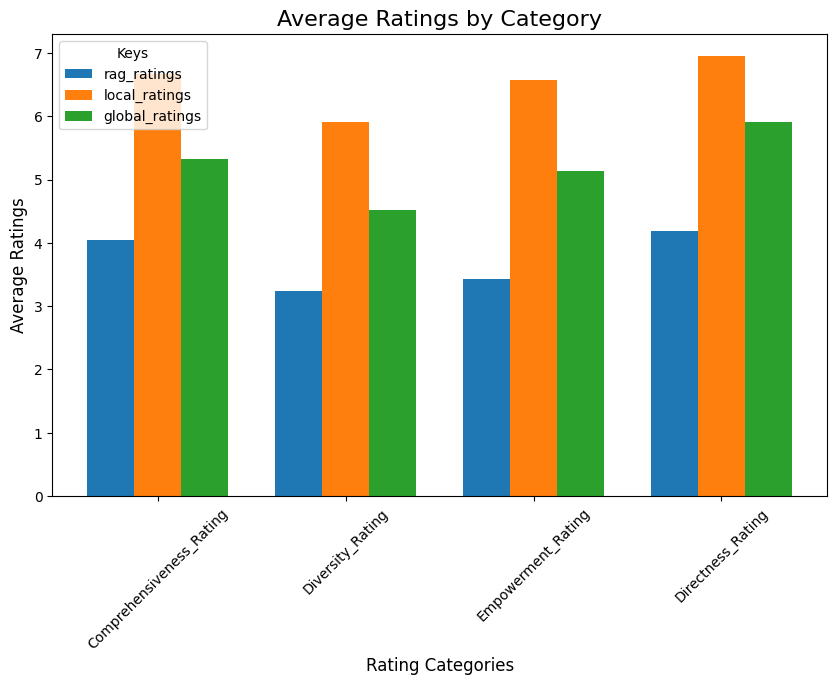

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example keys (replace with actual keys)
keys = ratings.keys()

# Ratings columns
ratings_columns = ['Comprehensiveness_Rating', 'Diversity_Rating', 'Empowerment_Rating', 'Directness_Rating']

# Bar width
bar_width = 0.25

# Number of categories (ratings_columns)
n_categories = len(ratings_columns)

# X-axis positions for the categories
x = np.arange(n_categories)

# Create the plot
plt.figure(figsize=(10, 6))

# Iterate through keys and plot the bars side by side
sum_per_questions = []
for i, k in enumerate(keys):
    # Load the data
    rag_ratings = pd.read_parquet(eval_path + k + '.parquet')
    data = rag_ratings[ratings_columns].astype(int)
    
    # Compute the mean ratings
    bars = data.sum() / data.count()
    sum_per_questions.append( data.sum(1) )
    
    
    # Shift the x positions for each key
    plt.bar(x + i * bar_width, bars.values, width=bar_width, label=k)

sum_per_questions = pd.DataFrame(sum_per_questions)
winners = sum_per_questions.idxmax(0)
w = winners.value_counts()
display(sum_per_questions)
display(winners)
display(w)
# Set x-tick positions and labels
plt.xticks(x + bar_width * (len(keys) - 1) / 2, ratings_columns, rotation=45)

# Add a horizontal dashed line at y=10
#plt.axhline(y=10, color='r', linestyle='--')

# Add labels and title
plt.xlabel('Rating Categories', fontsize=12)
plt.ylabel('Average Ratings', fontsize=12)
plt.title('Average Ratings by Category', fontsize=16)

# Add legend
plt.legend(title='Keys')

# Show the plot
plt.show()


In [23]:
result['local_search'] 

KeyError: 'local_search'

In [ ]:
from utils import answer_to_quesion,electronic_collection

print(question)

output = answer_to_quesion(electronic_collection,question)
print(output)

In [ ]:
result.context_data["entities"].head()

In [ ]:
result.context_data["relationships"].head()

In [ ]:
result.context_data["reports"].head()

In [ ]:
result.context_data["sources"].head()

In [ ]:
print(result.context_text)

In [ ]:
print(result.context_data['sources'])

In [ ]:
from graphrag.query.question_gen.local_gen import LocalQuestionGen

question_generator = LocalQuestionGen(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
)

In [ ]:
question_history = [
    "Tell me about soldering process",
    "What happens in cleaning soldering?",
]
candidate_questions = await question_generator.agenerate(
    question_history=question_history, context_data=None, question_count=5
)
print(candidate_questions.response)